<a href="https://colab.research.google.com/github/naman-mehta/predict_steering_angle/blob/master/selfdriving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The model is based on https://arxiv.org/pdf/1604.07316.pdf
End to End Learning for Self-Driving Cars by Nvidia

In [11]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')



TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp /content/drive/My\ Drive/07012018.zip /content/dataset.zip

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("/content/dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [8]:
!cd /content/dataset/data
!ls -1 | wc -l


63825


**Mounting Google Drive locally.** 
I have downloaded the SullyChen's auto pilot dataset from https://github.com/SullyChen/driving-datasets and got it uploaded back unzipped in my google drive.

In [29]:
data_dir="/content/dataset/"
with open( data_dir+'data.txt', 'r') as f:
  contents=f.read()
  
contents= list(contents.split('\n'))  
del contents[-1]
print("Total size of dataset =",len(contents))

TOTAL_SIZE_DATASET=len(contents)



Total size of dataset = 63825


Convert contents to tensorflow dataset

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(contents)
print(dataset.element_spec)

# print the 
for line in dataset.take(1):
  x=tf.strings.split(tf.strings.split(line, ',')[0],' ')[1]
  y=tf.strings.to_number(x)
  pi_on_180 = 0.017453292519943295
  a=tf.math.multiply(y,pi_on_180)  

#x=tf.strings.split(tf.strings.split(contents2, ',')[0],' ')[1]

TensorSpec(shape=(), dtype=tf.string, name=None)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
"""code with tensorflow tf.data.dataset"""
IMG_WIDTH=66
IMG_HEIGHT=200

#get label function returns label  
def get_label(file_path):
  #It takes out angle which is the second element in string 
  label_in_string = tf.strings.split(tf.strings.split(file_path, ',')[0],' ')[1]
  label_in_degree = tf.strings.to_number(label_in_string)
  pi_on_180 = 0.017453292519943295
  #convert it to radian and return 
  return tf.math.multiply(label_in_degree,pi_on_180)

#decode_img functions returns the resized image 
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

#process_path function returns image and label together
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(data_dir+'data/'+ tf.strings.split(file_path, ' ')[0])
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = dataset.map(process_path,num_parallel_calls=AUTOTUNE)
#Dataset.element_spec property allows us to inspect the type of each element component
print("Tensor specification",labeled_ds.element_spec)

#print the shape and angle of 1st image in dataset
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  
#WE CAN SPLIT THE DATASET HERE OR DURING CALL FOR TRAINING  
#split the dataset in 80:20 ratio
train = labeled_ds.take(TOTAL_SIZE_DATASET*0.8))
test = labeled_ds.skip(TOTAL_SIZE_DATASET*0.8))


Tensor specification (TensorSpec(shape=(66, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
Image shape:  (66, 200, 3)
Label:  0.0


Training and testing dataset
chek1
chek2


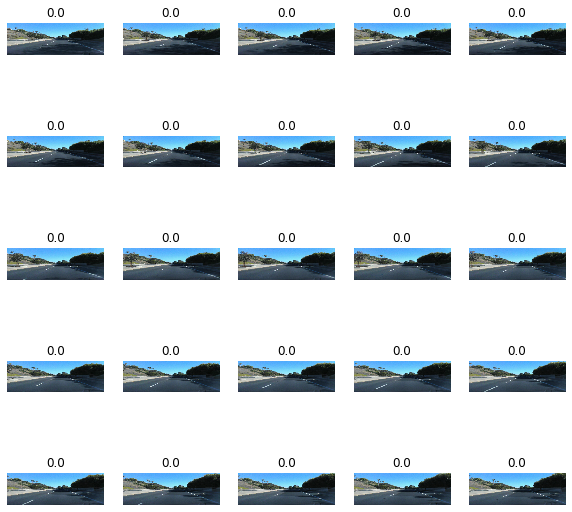

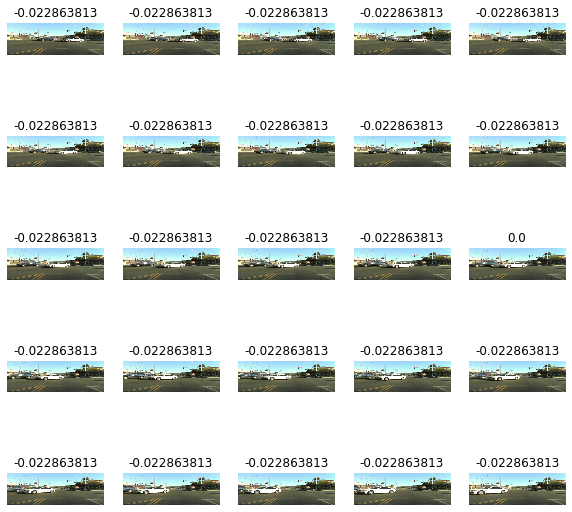

In [17]:
#repeat and batch. Inspect a batch.
EPOCHS = 30
BATCH_SIZE = 100


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')


def prepare_for_training(ds, cache=True):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(1000)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds


train_ds = prepare_for_training(train)
print("Training and testing dataset")
train_images, train_labels = next(iter(train_ds))

show_batch(train_images.numpy(), train_labels.numpy())

print("chek1")

test_ds = prepare_for_training(test)
print("chek2")
test_images, test_labels = next(iter(test_ds))

show_batch(test_images.numpy(), test_labels.numpy())



In [0]:
import time
default_timeit_steps = 11

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [20]:
timeit(train_ds)

..
11 batches: 23.342056274414062 s
47.12524 Images/s


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization

model = Sequential([
    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    Conv2D(filters=24,kernel_size = 5,strides=(2, 2),activation='relu',input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),

    Conv2D(filters=36,kernel_size = 5,strides=(2, 2),activation='relu'),
    BatchNormalization(),
   
    Conv2D(filters=48,kernel_size = 5,strides=(2, 2),activation='relu'),
    BatchNormalization(),

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    
    Conv2D(filters=64,kernel_size = 3,strides=(1, 1),activation='relu'),
    BatchNormalization(),
    
    Conv2D(filters=64,kernel_size = 3,strides=(1, 1),activation='relu'),
    BatchNormalization(),
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    Flatten(),
    
    # Fully connected layers
    Dense(1164, activation='relu'),
    BatchNormalization(),
    
    Dense(200, activation='relu'),
    BatchNormalization(),
    
    Dense(50, activation='relu'),
    BatchNormalization(),
    
    Dense(10, activation='relu'),
    BatchNormalization(),
   
    # Output layer
    Dense(1)
    
])    

   
    
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mae', 'mse'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 98, 24)        96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 22, 48)         192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         2

In [23]:
import os
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True, 
    verbose=1, 
    save_weights_only=True,
    period=10)


# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))



In [0]:
history = model.fit(train_ds,
                    steps_per_epoch = TOTAL_SIZE_DATASET*0.8 // BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data = test_ds,
                    validation_steps = TOTAL_SIZE_DATASET*0.2 // BATCH_SIZE,
                    callbacks=[cp_callback],
                    shuffle=False)

Train for 510.0 steps, validate for 127.0 steps
Epoch 1/30
509/510 [============================>.] - ETA: 0s - loss: 0.2114 - mae: 0.2716 - mse: 0.2114

In [0]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc)

Let us visualise the results after training the network.

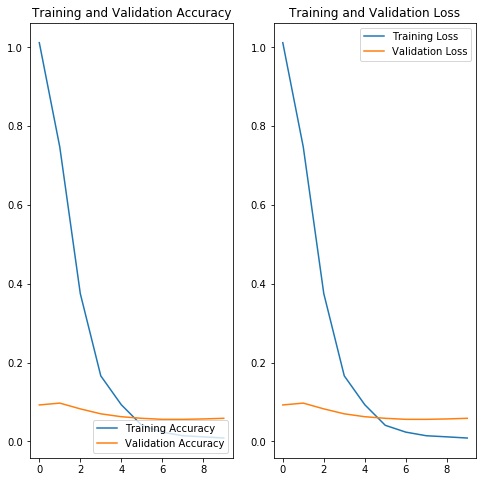

In [0]:
epochs=10
acc = history.history['mse']
val_acc = history.history['val_mse']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()